In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from pingouin import ancova
import sys

sys.path.append("../../")
from lib.general import get_stage_list
from lib.r_interface import tukey, tukey_multiple_dvs

Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.
c:\Users\m\Documents\medical-data\.venv\Lib\site-packages\rpy2\rinterface\__init__.py:1211: UserWarning: Environment variable "PATH" redefined by R and overriding existing variable. Current: "c:\Users\m\Documents\medical-data\.venv\Scripts;C:\Users\m\Documents\medical-data\.venv\Scripts;C:\VulkanSDK\1.4.328.1\Bin;C:\Python314\Scripts\;C:\Python314\;C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v13.0\bin\x64;C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v13.0\bin;C:\WINDOWS\system32;C:\WINDOWS;C:\WINDOWS\System32\Wbem;C:\WINDOWS\System32\WindowsPowerShell\v1.0\;C:\WINDOWS\System32\OpenSSH\;C:\Program Files (x86)\NVIDIA Corporation\PhysX\Common;C:\Program Files (x86)\Windows Kits\10\Windows Performance Toolkit\;C:\Program Files\NVIDIA Corporation\Nsight Compute 2025.3.0\;C:\Program Files\CMake\bin;C:\Program Files\Git\cmd;C:\Program Files\Docker\Docker\resources\

### Input

In [2]:
# Define I/O paths
path_demographics: Path = Path(
    "../../../data/processed/adni/demographics_biomarkers.csv"
).resolve()

In [3]:
# Read files
demographics: pd.DataFrame = pd.read_csv(path_demographics)
stage_list: list[str] = get_stage_list(2)

In [4]:
# Join dataframes
df: pd.DataFrame = demographics.copy()

### ANCOVA

In [5]:
# Convert bool columns to int
bool_cols: list[str] = df.select_dtypes(include=[bool]).columns.tolist()
df[bool_cols] = df[bool_cols].astype(int)

In [6]:
# For each lipid class, perform ANCOVA, and store the lipid classes that differ significantly between stages
lipid_differ_between_stages: list[str] = []
for lipid_class in ["strem2_log10"]:
    df_ancova: pd.DataFrame = ancova(
        data=df,
        dv=lipid_class,
        between="stage",
        covar=["age", "sex", "bmi", "cog", "apoe4"],
        effsize="np2",
    )
    if df_ancova["p-unc"].values[0] < 0.05:
        lipid_differ_between_stages.append(lipid_class)

In [7]:
lipid_differ_between_stages

['strem2_log10']

### Tukey HSD post hoc

In [8]:
df["ptau_log10"] = np.log10(df["ptau"])
df.to_csv("c:/Users/m/Documents/tb.csv", index=False)

In [9]:
# Perform Tukey's HSD test for the lipid classes that significantly differ between stages
tukey_result: pd.DataFrame = tukey(df, "strem2_log10", stage_list)
# Display only the significant p-values
tukey_result

R callback write-console: Loading required package: MASS
  
R callback write-console: 
Attaching package: 'TH.data'

  
R callback write-console: The following object is masked from 'package:MASS':

    geyser

  


,coef,lower,upper,std_err,p_adj
"(CSF-/PET-, CSF+/PET-)",0.147654,0.021483,0.273825,0.049522,0.014492
"(CSF-/PET-, CSF-/PET+)",0.041146,-0.051373,0.133666,0.036313,0.653978
"(CSF-/PET-, CSF+/PET+)",0.063614,-0.000428,0.127657,0.025136,0.051899
"(CSF+/PET-, CSF-/PET+)",-0.106508,-0.253543,0.040528,0.057711,0.238706
"(CSF+/PET-, CSF+/PET+)",-0.084040,-0.209688,0.041608,0.049316,0.306198
"(CSF-/PET+, CSF+/PET+)",0.022468,-0.075316,0.120251,0.038379,0.932316


In [10]:
tukey_result.to_csv("C:/Users/m/Downloads/tukey_result.csv", index=True)

In [11]:
# Perform ANCOVA for strem2_log10
ancova(
    data=df,
    dv="strem2_log10",
    between="stage",
    covar=["ptau", "age", "sex", "bmi", "cog", "apoe4"],
    effsize="np2",
)

,Source,SS,DF,F,p-unc,np2
0,stage,1.081891,3,9.227815,5.761007e-06,0.047106
1,ptau,7.229693,1,184.993522,1.311566e-36,0.248316
2,age,0.910336,1,23.293702,1.795814e-06,0.039935
3,sex,0.013866,1,0.354805,5.516464e-01,0.000633
4,bmi,0.254446,1,6.510779,1.098681e-02,0.011493
5,cog,0.007654,1,0.195859,6.582552e-01,0.000350
6,apoe4,0.074644,1,1.909984,1.675160e-01,0.003399
7,Residual,21.885242,560,NaN,NaN,NaN


In [12]:
# Perform Tukey's post-hoc for strem2_log10
tukey(df, "strem2_log10", stage_list)

,coef,lower,upper,std_err,p_adj
"(CSF-/PET-, CSF+/PET-)",0.147654,0.021754,0.273554,0.049522,0.014285
"(CSF-/PET-, CSF-/PET+)",0.041146,-0.051174,0.133467,0.036313,0.653962
"(CSF-/PET-, CSF+/PET+)",0.063614,-0.000291,0.127519,0.025136,0.051664
"(CSF+/PET-, CSF-/PET+)",-0.106508,-0.253227,0.040211,0.057711,0.238801
"(CSF+/PET-, CSF+/PET+)",-0.084040,-0.209417,0.041337,0.049316,0.306165
"(CSF-/PET+, CSF+/PET+)",0.022468,-0.075105,0.120040,0.038379,0.932300


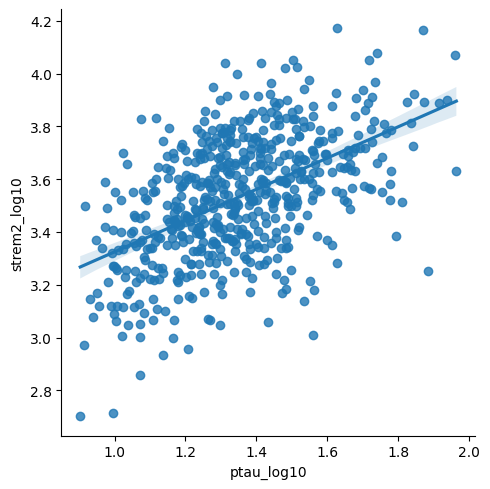

In [13]:
# plot strem2 against ptau with linear regression
import matplotlib.pyplot as plt
import seaborn as sns

sns.lmplot(data=df, x="ptau_log10", y="strem2_log10")
plt.show()

In [14]:
# find the correlation between strem2 and ptau
df[["strem2_log10", "ptau_log10"]].corr()

,strem2_log10,ptau_log10
strem2_log10,1.000000,0.519223
ptau_log10,0.519223,1.000000
